In [1]:
#
import os
import sys
import warnings
import copy
from pathlib import Path
from typing import Union, List

#
sys.path.append("./src/")
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")

# Stable Baseline3
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

#
import matplotlib
import pandas as pd
from finrl import config_tickers

#
from rl.plot.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from rl.envs.StockTradingEnv import StockTradingEnv
from rl.experiments._1_same_bigger_data_fundamental.train import (
    CustomDRLAgent,
    get_env_kwargs,
    base_cols,
    data_cols,
    ratios_cols,
)
from rl.experiments.common.utils import init_program
from rl.experiments.common.utils import ignore_warnings
from rl.experiments.common.classes import LearnedAlgorithm

#
from configuration.settings import ProjectDir, ExperimentDir
from rl.experiments._2_ta_orig.Env import StockPortfolioEnv
from rl.experiments._2_ta_orig.train import base_cols, data_cols, features_cols
from rl.experiments.common.classes import Program
from rl.experiments.common.utils import ignore_warnings
from rl.data.CompanyInfo import CompanyInfo

/Users/zlapik/my-drive-zlapik/0-todo/ai-investing/venv3.10/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
ignore_warnings()

In [ ]:
_TRAIN_DATA_START = "2010-01-01"
_TRAIN_DATE_END = "2021-12-31"
_TEST_DATA_START = "2021-01-01"
_TEST_DATA_END = "2021-12-31"

In [3]:
program = init_program()

In [ ]:
#
program = Program(
    prj_dir=ProjectDir(root=Path("/Users/zlapik/my-drive-zlapik/0-todo/ai-investing")),
    exp_dir=ExperimentDir(root=Path(os.getcwd())),
    DEBUG=False,
)
program.exp_dir.check_and_create_dirs()

#
TICKERS = copy.deepcopy(config_tickers.DOW_30_TICKER)
TICKERS.remove("DOW")  # TODO: I don't have all necessary data for "DOW"

In [4]:
print(TICKERS)
print(program.prj_dir.root)
print(program.exp_dir.root)
print(base_cols)
print(data_cols)
print(features_cols)

['date', 'tic']
['open', 'high', 'low', 'close', 'volume']
['operatingProfitMargin', 'netProfitMargin', 'returnOnAssets', 'returnOnEquity', 'currentRatio', 'quickRatio', 'cashRatio', 'inventoryTurnover', 'receivablesTurnover', 'payablesTurnover', 'debtRatio', 'debtEquityRatio', 'priceEarningsRatio', 'priceBookValueRatio', 'dividendYield']


In [6]:
# LearnedAlgorithm.__init__.__code__.co_varnames

In [7]:
def get_algorithm(filename: Path):
    if "a2c" in filename.as_posix():
        return LearnedAlgorithm(algorithm="a2c", filename=filename, learned_algorithm=A2C.load(filename))


learned_algorithms = []
for filepath in program.exp_dir.out.algorithms.glob("*"):
    learned_algorithms.append(get_algorithm(filepath))
    break

In [8]:
# Test Learned Algorithms
print(len(learned_algorithms))
for algo in learned_algorithms:
    env_kwargs = get_env_kwargs(program.dataset)
    env_gym = StockTradingEnv(df=program.dataset, **env_kwargs)
    algo.df_account_value, algo.df_actions = CustomDRLAgent.DRL_prediction(
        model=algo.learned_algorithm, environment=env_gym
    )
# algos_prediction = predicate(program, learned_algorithms)

1
Stock Dimension: 29, State Space: 494
hit end!


In [9]:
# print(learned_algorithms[0].df_actions)
# print(learned_algorithms[0].df_account_value)

In [10]:
metric = "Annual return"

for algo in learned_algorithms:
    perf_stats_all = backtest_stats(account_value=algo.df_account_value)
    algo.perf_stats_all = pd.DataFrame(perf_stats_all)

In [11]:
def print_learned_algo(algos: List[LearnedAlgorithm]):
    for i in algos:
        try:
            print(i.perf_stats_all.loc[metric][0])
        except Exception as e:
            print(f"{e}")


print_learned_algo(learned_algorithms)

0.07411332268519666


In [12]:
sorted_list = sorted(learned_algorithms, key=lambda x: x.perf_stats_all.loc[metric][0])

In [13]:
# print_learned_algo(sorted_list)
# print(f"{sorted_list[len(sorted_list)].filename}")

best_idx = len(sorted_list) - 1
worst_idk = 0


def get_annual_return(algo: LearnedAlgorithm):
    return algo.perf_stats_all.loc[metric][0]


print(f"{get_annual_return(sorted_list[best_idx])}:  {sorted_list[best_idx].filename.name}")
print(f"{get_annual_return(sorted_list[worst_idk])}:  {sorted_list[worst_idk].filename.name}")

0.07411332268519666:  a2c_2022-12-20T13-16-18_10000.zip
0.07411332268519666:  a2c_2022-12-20T13-16-18_10000.zip


In [14]:
stats = backtest_stats(sorted_list[best_idx].df_account_value)
stats

Annual return          0.074113
Cumulative returns     0.301198
Annual volatility      0.224857
Sharpe ratio           0.431067
Calmar ratio           0.212117
Stability              0.633384
Max drawdown          -0.349398
Omega ratio            1.091195
Sortino ratio          0.604968
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.994337
Daily value at risk   -0.027945
dtype: float64

In [15]:
start = program.dataset["date"].min()
end = program.dataset["date"].max()
print(f"Start: {start}  -  End: {end}")

Start: 2019-04-12  -  End: 2022-12-15


In [16]:
# Baseline
baseline_df = get_baseline("^DJI", start, end)

In [17]:
baseline_df

,date,open,high,low,close,volume,dividends,stock splits
Date,,,,,,,,
2019-04-12,2019-04-12,26357.789062,26436.679688,26309.720703,26412.300781,369910000,0.0,0.0
2019-04-15,2019-04-15,26407.759766,26424.849609,26316.419922,26384.769531,250620000,0.0,0.0
2019-04-16,2019-04-16,26482.189453,26530.710938,26397.189453,26452.660156,302340000,0.0,0.0
2019-04-17,2019-04-17,26468.529297,26501.019531,26391.859375,26449.539062,367780000,0.0,0.0
2019-04-18,2019-04-18,26463.369141,26602.419922,26444.529297,26559.539062,332850000,0.0,0.0
...,...,...,...,...,...,...,...,...
2022-12-08,2022-12-08,33695.968750,33899.171875,33642.460938,33781.480469,271830000,0.0,0.0
2022-12-09,2022-12-09,33746.710938,33844.628906,33462.648438,33476.460938,287630000,0.0,0.0
2022-12-12,2022-12-12,33519.500000,34005.039062,33519.500000,34005.039062,313440000,0.0,0.0


In [18]:
print(baseline_df.index.min())
print(baseline_df.index.max())

2019-04-12
2022-12-14


In [19]:
stats = backtest_stats(baseline_df, value_col_name="close")

stats

Annual return          0.070772
Cumulative returns     0.286005
Annual volatility      0.232728
Sharpe ratio           0.411239
Calmar ratio           0.190831
Stability              0.561379
Max drawdown          -0.370862
Omega ratio            1.087791
Sortino ratio          0.567932
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.953450
Daily value at risk   -0.028941
dtype: float64

Start date,2019-04-12
End date,2022-12-14
Total months,44
,Backtest
Annual return,7.077%
Cumulative returns,28.601%
Annual volatility,23.273%
Sharpe ratio,0.41
Calmar ratio,0.19
Stability,0.56
Max drawdown,-37.086%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.09,2020-02-12,2020-03-23,2020-11-16,199
1,21.94,2022-01-04,2022-09-30,NaT,NaN
2,6.91,2019-04-23,2019-05-31,2019-06-20,43
3,6.87,2019-07-15,2019-08-14,2019-11-04,81
4,6.62,2021-11-08,2021-12-01,2021-12-29,38


Stress Events,mean,min,max
New Normal,0.04%,-12.93%,11.37%


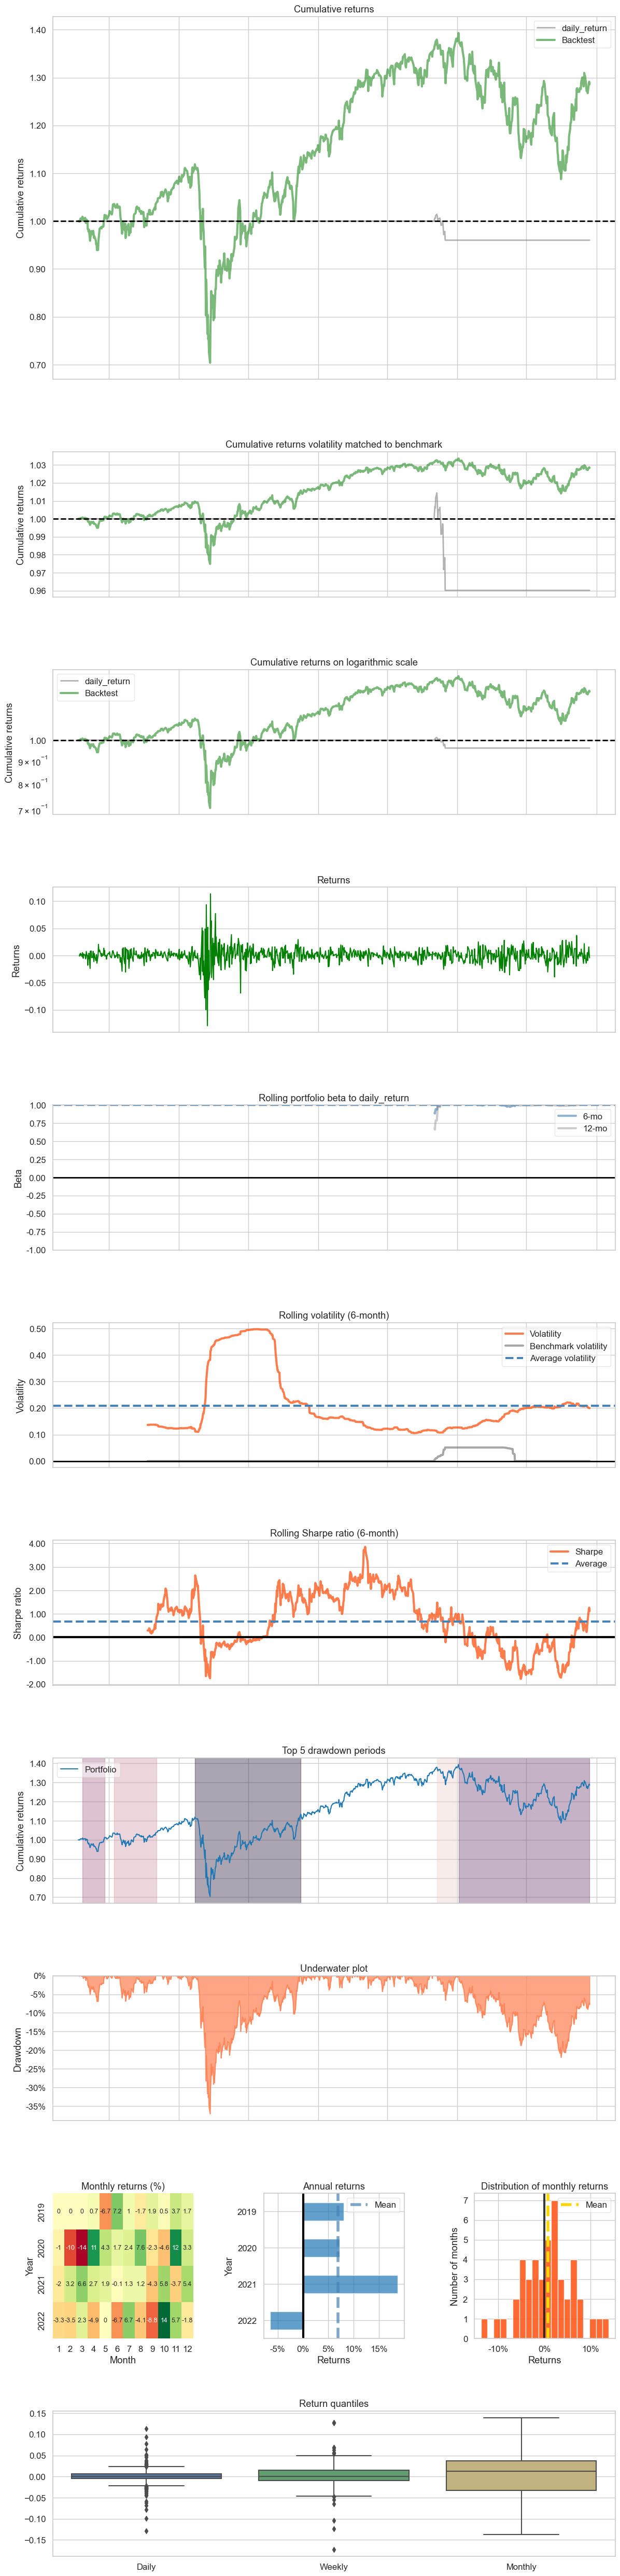

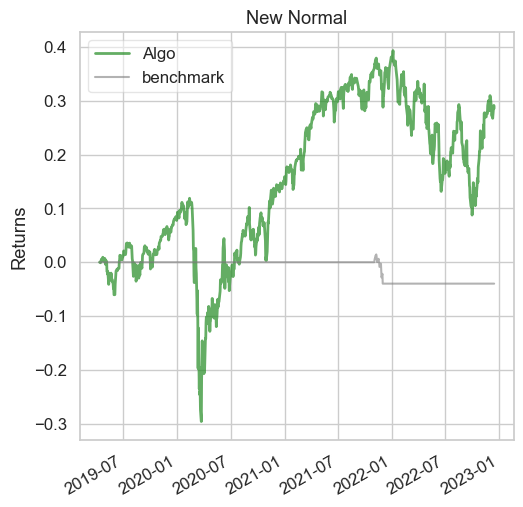

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
backtest_plot(baseline_df, value_col_name="close")